Running on cpu
原始信号: N=1024, K=50
测量次数: M=256 (压缩比 4.0x)
[Operator Info] Input: 1024 -> RFFT Complex: 513 -> Flattened Real: 1026
测量值 y shape: torch.Size([256]) (纯实数)
开始 ISTA 重建...
重建 MSE: 0.00062683


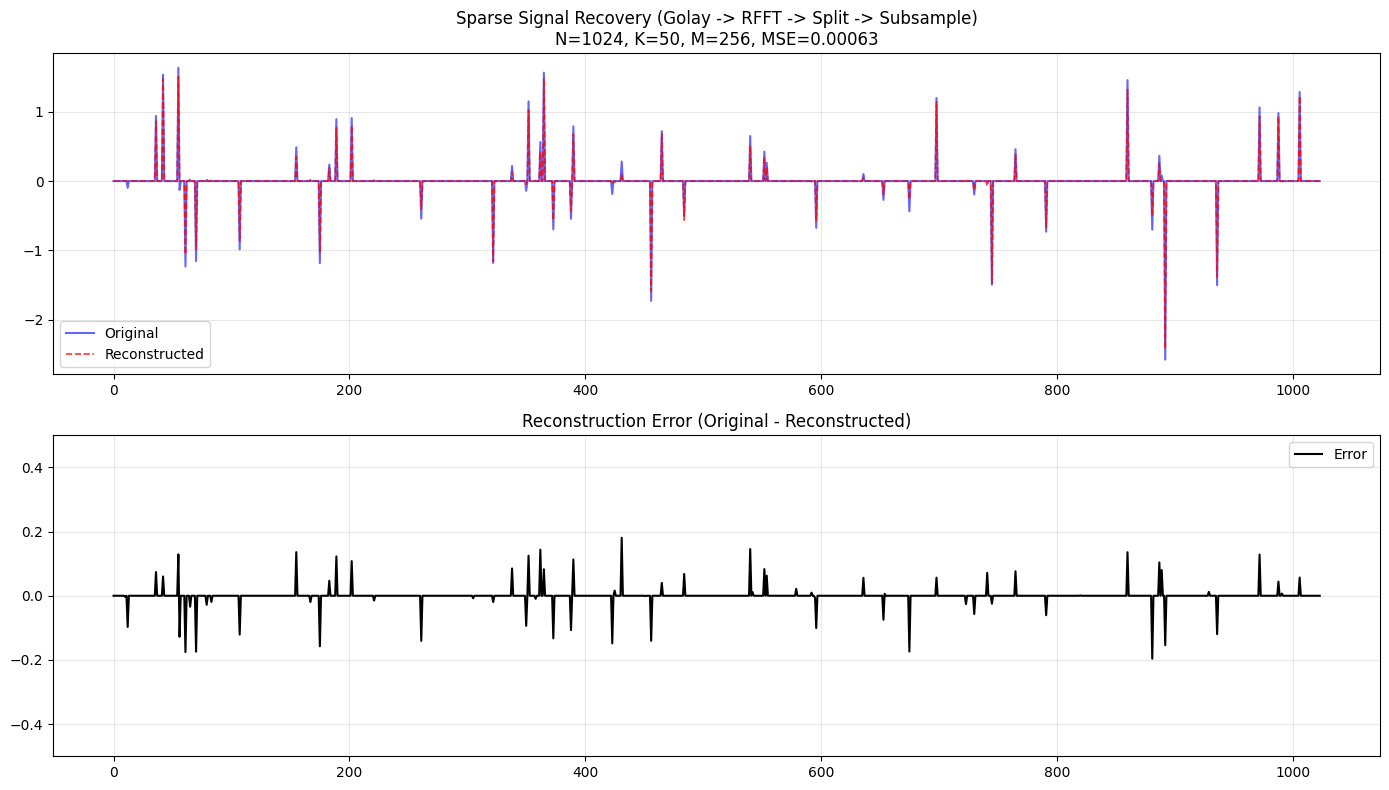

In [20]:
import torch
import torch.fft
import math
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Golay 序列生成 (和你提供的一致)
# ==========================================
def generate_golay_sequence(n):
    if n <= 0: return torch.tensor([])
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)

    def _recursive(k):
        if k == 1: 
            return torch.tensor([1.]), torch.tensor([1.])
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])

    full_seq, _ = _recursive(N)
    return full_seq[:n]

# ==========================================
# 2. 压缩感知算子: Golay + RFFT + Real/Imag Split
# ==========================================
class CS_Operator_RFFT_Real:
    def __init__(self, n, m, device='cpu'):
        self.n = n # 原始长度 (e.g. 1024)
        self.m = m # 测量长度 (e.g. 256)
        self.device = device
        
        # 1. Golay 序列
        self.golay = generate_golay_sequence(n).to(device)
        
        # 2. 计算 RFFT 后的维度
        # rfft 输出形状为 n // 2 + 1
        self.complex_dim = n // 2 + 1
        # 拼接 real 和 imag 后的总长度
        self.flatten_dim = self.complex_dim * 2
        
        print(f"[Operator Info] Input: {n} -> RFFT Complex: {self.complex_dim} -> Flattened Real: {self.flatten_dim}")
        
        # 3. 生成随机采样掩码 (在 Flatten 后的实数域上采样)
        # 我们从 1026 个实数值中选 m 个
        self.mask_indices = torch.randperm(self.flatten_dim, device=device)[:m]
        
    def forward(self, x):
        """
        压缩过程: x (实数) -> y (实数)
        """
        # 1. Golay 调制
        x_mod = x * self.golay
        
        # 2. RFFT (Real to Complex)
        # norm='ortho' 保证变换近似正交
        x_freq = torch.fft.rfft(x_mod, norm='ortho')
        
        # 3. 拆分实部虚部并拼接 (参考你的 CompressModel)
        # shape: [..., complex_dim] -> [..., complex_dim * 2]
        real_part = x_freq.real
        imag_part = x_freq.imag
        x_flat = torch.cat([real_part, imag_part], dim=-1)
        
        # 4. 下采样 (Selection)
        if x.ndim == 1:
            y = x_flat[self.mask_indices]
        else:
            y = x_flat[:, self.mask_indices]
            
        return y

    def adjoint(self, y):
        """
        伴随算子 (用于重建): y (实数) -> x_hat (实数)
        """
        # 1. 恢复全尺寸的实数向量 (Zero Filling)
        batch_size = y.shape[0] if y.ndim > 1 else 1
        
        if y.ndim == 1:
            x_flat_recon = torch.zeros(self.flatten_dim, dtype=y.dtype, device=self.device)
            x_flat_recon[self.mask_indices] = y
        else:
            x_flat_recon = torch.zeros(batch_size, self.flatten_dim, dtype=y.dtype, device=self.device)
            x_flat_recon[:, self.mask_indices] = y
            
        # 2. 拆解回实部和虚部
        # x_flat 是 [Real | Imag] 拼接的
        # split_size = self.complex_dim
        real_recon = x_flat_recon[..., :self.complex_dim]
        imag_recon = x_flat_recon[..., self.complex_dim:]
        
        # 3. 组合成复数
        x_freq_recon = torch.complex(real_recon, imag_recon)
        
        # 4. IRFFT (Complex to Real)
        # 注意指定输出长度 n，防止奇偶歧义
        x_mod_recon = torch.fft.irfft(x_freq_recon, n=self.n, norm='ortho')
        
        # 5. Golay 解调
        x_recon = x_mod_recon * self.golay
        
        return x_recon

# ==========================================
# 3. ISTA 求解器
# ==========================================
def solve_ista(operator, y, lambda_l1=0.1, n_iters=10000, lr=0.5):
    """
    ISTA: Iterative Soft Thresholding Algorithm
    min ||y - Ax||^2 + lambda ||x||_1
    """
    # 初始化 x
    if y.ndim > 1:
        x = torch.zeros(y.shape[0], operator.n, device=operator.device)
    else:
        x = torch.zeros(operator.n, device=operator.device)
        
    losses = []
    
    for i in range(n_iters):
        # 1. 梯度更新 (Landweber iteration)
        # residual = Ax - y
        # grad = A^T(Ax - y)
        measure_est = operator.forward(x)
        residual = measure_est - y
        grad = operator.adjoint(residual)
        
        z = x - lr * grad
        
        # 2. 软阈值 (Proximal Operator for L1)
        threshold = lambda_l1 * lr
        x = torch.sign(z) * torch.maximum(torch.abs(z) - threshold, torch.tensor(0.0, device=x.device))
        
        if i % 100 == 0:
            loss = 0.5 * torch.norm(residual)**2 + lambda_l1 * torch.norm(x, p=1)
            losses.append(loss.item())
            
    return x, losses

# ==========================================
# 4. 主程序
# ==========================================
def main():
    #torch.manual_seed()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on {device}")
    
    # --- 参数 ---
    N = 1024        # 信号长度
    K = 50          # 稀疏度
    M = 256         # 采样点数 (实数) -> 压缩率 25%
    
    # --- 1. 生成稀疏信号 ---
    x_gt = torch.zeros(N, device=device)
    indices = torch.randperm(N)[:K]
    values = torch.randn(K, device=device)
    x_gt[indices] = values
    
    print(f"原始信号: N={N}, K={K}")
    print(f"测量次数: M={M} (压缩比 {N/M:.1f}x)")
    
    # --- 2. 采样 (Encoding) ---
    cs_op = CS_Operator_RFFT_Real(N, M, device)
    y = cs_op.forward(x_gt)
    
    print(f"测量值 y shape: {y.shape} (纯实数)")
    
    # --- 3. 重建 (Decoding) ---
    print("开始 ISTA 重建...")
    # lambda_l1 控制稀疏度惩罚，lr 控制步长
    x_recon, loss_hist = solve_ista(cs_op, y, lambda_l1=0.02, n_iters=3000, lr=0.9)
    
    # --- 4. 结果分析 ---
    mse = torch.mean((x_gt - x_recon)**2).item()
    print(f"重建 MSE: {mse:.8f}")
    
    # --- 5. 绘图 ---
    x_gt_np = x_gt.cpu().numpy()
    x_recon_np = x_recon.cpu().numpy()
    
    plt.figure(figsize=(14, 8))
    
    # 子图1: 原始 vs 重建
    plt.subplot(2, 1, 1)
    plt.title(f"Sparse Signal Recovery (Golay -> RFFT -> Split -> Subsample)\nN={N}, K={K}, M={M}, MSE={mse:.5f}")
    plt.plot(x_gt_np, 'b', label='Original', alpha=0.6, linewidth=1.5)
    plt.plot(x_recon_np, 'r--', label='Reconstructed', alpha=0.8, linewidth=1.2)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 误差
    plt.subplot(2, 1, 2)
    plt.title("Reconstruction Error (Original - Reconstructed)")
    plt.plot(x_gt_np - x_recon_np, 'k', label='Error')
    plt.ylim([-0.5, 0.5]) # 固定一下范围看清噪声
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

In [191]:
import torch
import torch.fft
import math
import time
import numpy as np

# ==========================================
# 1. Golay 序列生成器 (支持任意长度截断)
# ==========================================
def generate_golay_sequence(n, device='cpu'):
    """生成长度为 n 的 Golay 序列 (+1/-1)"""
    if n <= 0: return torch.tensor([], device=device)
    
    # 向上取整到最近的 2^k
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)

    def _recursive(k):
        if k == 1: 
            return torch.tensor([1.], device=device), torch.tensor([1.], device=device)
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])

    full_seq, _ = _recursive(N)
    return full_seq[:n]

# ==========================================
# 2. 两种变换层的实现
# ==========================================

class RFFT_Layer(torch.nn.Module):
    """基于 RFFT 的混合层"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        # 1. RFFT (实数 -> 复数)
        # norm='ortho' 保持能量
        x_freq = torch.fft.rfft(x, dim=-1, norm='ortho')
        
        # 2. 拼接实部虚部 (复数 -> 实数)
        # 这一步是为了模拟真实使用场景，必须包含在耗时里
        x_out = torch.cat([x_freq.real, x_freq.imag], dim=-1)
        
        # 3. 截断/对齐到原始维度
        return x_out[..., :self.dim]

class Block_FWHT_Layer(torch.nn.Module):
    """基于分块 FWHT 的混合层"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # 寻找最大的 2^k 因子
        self.sub_dim = 1
        temp = dim
        while temp % 2 == 0:
            self.sub_dim *= 2
            temp //= 2
        self.num_blocks = dim // self.sub_dim
        
        # 如果无法分解（比如素数），则 sub_dim=1，这会变得极慢，这里假设能分解
        
    def forward(self, x):
        # 1. Reshape 分块
        B, N = x.shape
        x = x.view(B, self.num_blocks, self.sub_dim)
        
        # 2. 核心 FWHT (非递归 Butterfly 实现)
        # 这种写法减少了 Python 递归开销
        h = x
        h_dim = 1
        n = self.sub_dim
        
        # 归一化因子
        scale = 1.0 / math.sqrt(n)
        
        while h_dim < n:
            h = h.view(B, self.num_blocks, n // (2 * h_dim), 2, h_dim)
            a = h[..., 0, :]
            b = h[..., 1, :]
            h = torch.cat([a + b, a - b], dim=-1)
            h_dim *= 2
            
        h = h.view(B, N)
        return h * scale

# ==========================================
# 3. 基准测试工具 (Benchmark)
# ==========================================
def benchmark(model, x, loops=1000, desc="Model"):
    device = x.device
    model.eval()
    
    # 预热 (Warmup)
    for _ in range(100):
        _ = model(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    # 计时
    start = time.time()
    for _ in range(loops):
        _ = model(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    
    avg_time = (end - start) / loops * 1000 # ms
    print(f"[{desc}] 平均耗时: {avg_time:.4f} ms")
    return avg_time

# ==========================================
# 4. 主运行
# ==========================================
def main():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Testing on GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Testing on CPU (注意：CPU上结果可能不同)")

    # --- 设置参数 ---
    BATCH_SIZE = 256
    DIMS = [192, 384, 768, 1024] # Tiny, Small, Base, Standard 2^k
    LOOPS = 2000

    print(f"Batch Size: {BATCH_SIZE}, Loops: {LOOPS}\n")

    for dim in DIMS:
        print(f"--- Dimension: {dim} ---")
        x = torch.randn(BATCH_SIZE, dim, device=device)
        
        # 1. 实例化模型
        rfft_layer = RFFT_Layer(dim).to(device)
        fwht_layer = Block_FWHT_Layer(dim).to(device)
        
        # 2. 打印 FWHT 分块信息
        print(f"FWHT Strategy: {fwht_layer.num_blocks} blocks of size {fwht_layer.sub_dim}")
        
        # 3. 运行测试
        t_rfft = benchmark(rfft_layer, x, loops=LOOPS, desc="RFFT (Torch)")
        t_fwht = benchmark(fwht_layer, x, loops=LOOPS, desc="FWHT (Block)")
        
        # 4. 结论
        ratio = t_fwht / t_rfft
        winner = "RFFT" if t_rfft < t_fwht else "FWHT"
        print(f"-> {winner} is faster (Ratio: {ratio:.2f}x)\n")

if __name__ == '__main__':
    main()

Testing on CPU (注意：CPU上结果可能不同)
Batch Size: 256, Loops: 2000

--- Dimension: 192 ---
FWHT Strategy: 3 blocks of size 64
[RFFT (Torch)] 平均耗时: 0.0825 ms
[FWHT (Block)] 平均耗时: 0.2808 ms
-> RFFT is faster (Ratio: 3.40x)

--- Dimension: 384 ---
FWHT Strategy: 3 blocks of size 128
[RFFT (Torch)] 平均耗时: 0.1497 ms
[FWHT (Block)] 平均耗时: 0.4616 ms
-> RFFT is faster (Ratio: 3.08x)

--- Dimension: 768 ---
FWHT Strategy: 3 blocks of size 256
[RFFT (Torch)] 平均耗时: 0.2364 ms
[FWHT (Block)] 平均耗时: 0.8410 ms
-> RFFT is faster (Ratio: 3.56x)

--- Dimension: 1024 ---
FWHT Strategy: 1 blocks of size 1024
[RFFT (Torch)] 平均耗时: 0.3003 ms
[FWHT (Block)] 平均耗时: 1.2081 ms
-> RFFT is faster (Ratio: 4.02x)



In [ ]:
import torch
import torch.nn as nn
import math

def generate_golay_sequence(n):
    if n <= 0: return torch.tensor([])
    exponent = math.ceil(math.log2(n))
    N = 2 ** int(exponent)
    def _recursive(k):
        if k == 1: return torch.tensor([1.]), torch.tensor([1.])
        a, b = _recursive(k // 2)
        return torch.cat([a, b]), torch.cat([a, -b])
    return _recursive(N)[0][:n]

def fwht(x):
    # 简化的 Block FWHT 模拟
    # 这里假设 x 是 2 的幂次，或者已经处理过
    n = x.shape[-1]
    if (n & (n-1)) != 0: # 简单的 Padding 处理 demo
        pad = 2**math.ceil(math.log2(n)) - n
        x = torch.nn.functional.pad(x, (0, pad))
    
    # 快速哈达玛变换
    h = x.clone()
    h_dim = 1
    while h_dim < h.shape[-1]:
        h = h.view(*h.shape[:-1], -1, 2, h_dim)
        a, b = h[..., 0, :], h[..., 1, :]
        h = torch.cat([a+b, a-b], dim=-1)
        h_dim *= 2
    h = h.view(*x.shape) / math.sqrt(h.shape[-1]) # 归一化
    
    if (n & (n-1)) != 0:
        h = h[..., :n] # 截断回原始维度
    return h

def main():
    torch.manual_seed(42)
    dim = 768
    
    # 1. 准备数据
    x = torch.randn(1, dim)*10 # 输入
    w = torch.randn(dim, dim) # 权重矩阵 (模拟 Linear 层)
    golay = generate_golay_sequence(dim)
    
    # 2. 计算 RMS Norm
    rms = torch.sqrt(x.pow(2).mean() + 1e-6)
    x_norm = x / rms
    
    # --- 实验 1: 你的两种缩放方案对比 ---
    # 方案 A: 保持归一化
    y_A = fwht(x_norm * golay)
    # 方案 B: 乘回系数 (相当于 fwht(x * golay))
    y_B = y_A * rms 
    
    print(f"原始 x 范数: {x.norm().item():.4f}")
    print(f"方案 A (Norm) 范数: {y_A.norm().item():.4f}")
    print(f"方案 B (Rescale) 范数: {y_B.norm().item():.4f}")
    print("-> 结论: 方案 B 把能量还原了，方案 A 保持单位能量。\n")
    
    # --- 实验 2: 双侧变换 (Dual Transform) 验证 ---
    print("验证: <Transform(x), Transform(w)> == <x, w> ?")
    
    # 原始 Linear
    # y = x @ w.T
    out_original = torch.matmul(x, w.T)
    
    # 变换域 Linear
    # 1. 对 x 变换
    x_hat = fwht(x * golay)
    # 2. 对 w 的每一行变换 (注意是对 weights 进行同样的变换)
    w_hat = fwht(w * golay) # 广播乘法
    
    # 3. 在变换域做点积
    out_transformed = torch.matmul(x_hat, w_hat.T)
    
    # 比较
    diff = torch.abs(out_original - out_transformed).mean()
    relative_err = diff / out_original.abs().mean()
    
    print(f"原始输出均值: {out_original.mean().item():.4f}")
    print(f"变换输出均值: {out_transformed.mean().item():.4f}")
    print(f"相对误差: {relative_err.item():.8f}")
    
    if relative_err < 1e-5:
        print("✅ 验证成功: 全维度下，双侧变换在数学上等价于原始点积。")
        print("   (这意味着除非你做下采样/压缩，否则这么做只是增加了计算量)")
    else:
        print("❌ 误差较大，可能是 FWHT 的 Padding 导致了部分能量泄露")

if __name__ == '__main__':
    main()

原始 x 范数: 27.6725
方案 A (Norm) 范数: 27.7128
方案 B (Rescale) 范数: 27.6725
-> 结论: 方案 B 把能量还原了，方案 A 保持单位能量。

验证: <Transform(x), Transform(w)> == <x, w> ?
原始输出均值: 0.3810
变换输出均值: 0.3810
相对误差: 0.00000020
✅ 验证成功: 全维度下，双侧变换在数学上等价于原始点积。
   (这意味着除非你做下采样/压缩，否则这么做只是增加了计算量)
